In [55]:
# Import necessary libraries for decision tree implementation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [56]:
# Load breast cancer dataset
# Dataset contains features of cell nuclei with diagnosis (M=Malignant, B=Benign)
data = pd.read_csv("Datasets\data.csv")
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [57]:
# Prepare features and target variable
X = data.drop(columns=['diagnosis', 'id']).values  # Features (all columns except diagnosis and id)
y = data['diagnosis'].map({'M': 1, 'B': 0}).values.reshape(-1, 1)  # Encode target: M=1, B=0

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(455, 30) (114, 30) (455, 1) (114, 1)


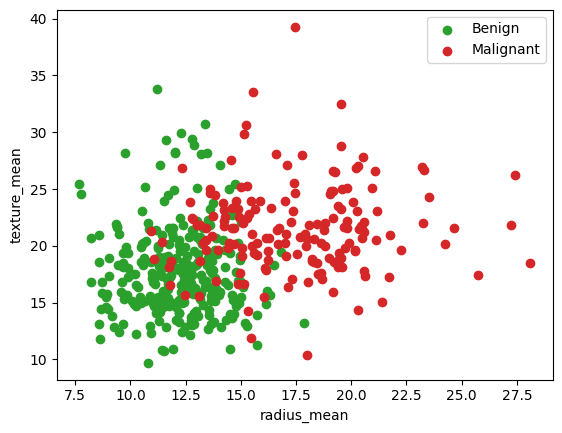

In [58]:
# Extract data points for visualization
# Get all benign (B) tumor data points from training set
benign_points = X_train[y_train[:, 0] == 0]
# Get all malignant (M) tumor data points from training set
malignant_points = X_train[y_train[:, 0] == 1]

# Create a scatter plot to visualize the data distribution
# Plot benign tumors in green
plt.scatter(benign_points[:, 0], benign_points[:, 1], color="tab:green", label="Benign")
# Plot malignant tumors in red
plt.scatter(
    malignant_points[:, 0], malignant_points[:, 1], color="tab:red", label="Malignant"
)
# Add axis labels (using first two features: radius_mean and texture_mean)
plt.xlabel("radius_mean")
plt.ylabel("texture_mean")
plt.legend()
plt.show()

In [59]:
# Node class represents each node in the decision tree
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        # For internal nodes: split criteria
        self.feature_index = feature_index  # Which feature to split on
        self.threshold = threshold          # Threshold value for splitting
        self.left = left                   # Left subtree
        self.right = right                 # Right subtree
        self.info_gain = info_gain         # Information gain from this split
        
        # For leaf nodes: prediction value
        self.value = value                 # Class prediction (for leaf nodes)

In [60]:
# Decision Tree Classifier implementation from scratch
class DecisionTreeClassifier():
    def __init__(self, min_sample_split, max_depth, criterion="entropy"):
        self.root = None
        self.min_sample_split = min_sample_split  # Minimum samples required to split
        self.max_depth = max_depth               # Maximum depth of the tree
        self.criterion = criterion               # Splitting criterion: "entropy" or "gini"

    def fit(self, X, y):
        """Train the decision tree on training data"""
        dataset = np.concatenate((X, y), axis=1)
        self.root = self.build_tree(dataset)

    def build_tree(self, dataset, curr_depth = 0):
        """Recursively build the decision tree"""
        X, y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = X.shape

        # Check stopping criteria: enough samples and not too deep
        if num_samples >= self.min_sample_split and curr_depth <= self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)

            # If we found a good split (positive information gain)
            if best_split.get("info_gain", 0) > 0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)

                return Node(best_split["feature_index"], best_split["threshold"], 
                          left_subtree, right_subtree, best_split["info_gain"])
            
        # Create leaf node with most frequent class
        leaf_node = self.leaf_node(y)
        return Node(value=leaf_node)
        
    def get_best_split(self, dataset, num_samples, num_features):
        """Find the best feature and threshold to split on"""
        best_split = {}
        max_info_gain = -float("inf")

        # Try all features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            
            # Try all possible thresholds for this feature
            for i in range(len(possible_thresholds)):
                threshold = (possible_thresholds[i] + possible_thresholds[i-1]) / 2
                dataset_left, dataset_right = self.split(feature_index, dataset, threshold)

                # Only consider splits that create non-empty subsets
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, y_left, y_right = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]

                    # Calculate information gain for this split
                    curr_info_gain = self.information_gain(y, y_left, y_right, self.criterion)

                    # Keep track of the best split
                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
        
        return best_split
    
    def split(self, feature_index, dataset, threshold):
        """Split dataset based on feature and threshold"""
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, left_child, right_child, criterion):
        """Calculate information gain from a split"""
        weight_left = len(left_child) / len(parent)
        weight_right = len(right_child) / len(parent)

        if criterion == "entropy":
            info_gain_val = self.entropy(parent) - (weight_left * self.entropy(left_child) + weight_right * self.entropy(right_child))
        elif criterion == "gini":
            info_gain_val = self.gini(parent) - (weight_left * self.gini(left_child) + weight_right * self.gini(right_child))
        return info_gain_val
    
    def entropy(self, y):
        """Calculate entropy: -Σ(p_i * log2(p_i))"""
        entropy_val = 0
        class_labels = np.unique(y)

        for _class in class_labels:
            prob_class = len(y[y == _class]) / len(y)
            entropy_val += -prob_class * np.log2(prob_class)

        return entropy_val
    
    def gini(self, y):
        """Calculate Gini impurity: 1 - Σ(p_i^2)"""
        gini_val = 1
        class_labels = np.unique(y)

        for _class in class_labels:
            prob_class = len(y[y==_class]) / len(y)
            gini_val -= prob_class ** 2
        return gini_val
    
    def leaf_node(self, y):
        """Return the most frequent class (majority vote)"""
        unique_classes, counts = np.unique(y, return_counts=True)
        most_common_class = unique_classes[np.argmax(counts)]
        return most_common_class

    def make_predictions(self, X, tree: Node):
        """Make prediction for a single sample by traversing the tree"""
        if tree.value is not None:  # Leaf node
            return tree.value
        
        feature_val = X[tree.feature_index]

        # Traverse left or right based on threshold
        if feature_val <= tree.threshold:
            return self.make_predictions(X, tree.left)
        else:
            return self.make_predictions(X, tree.right)

    def predicts(self, X):
        """Make predictions for multiple samples"""
        predictions = []

        for data_point in X:
            prediction = self.make_predictions(data_point, self.root)
            predictions.append(prediction)
        
        return np.array(predictions)
    
    def print_tree(self, tree=None, depth=0):
        """Print the tree structure for visualization"""
        if tree is None:
            tree = self.root
        
        if tree.value is not None:
            print("  " * depth, "Leaf:", tree.value)
        else:
            print("  " * depth, f"[X{tree.feature_index} <= {tree.threshold}] (Info Gain: {tree.info_gain})")
            self.print_tree(tree.left, depth + 1)
            self.print_tree(tree.right, depth + 1)

In [61]:
# Train the decision tree model
# Parameters: min_sample_split=3 (need at least 3 samples to split), max_depth=3 (limit tree depth)
dt_model = DecisionTreeClassifier(min_sample_split=3, max_depth=3)
dt_model.fit(X_train, y_train)
dt_model.print_tree()  # Visualize the trained tree structure

 [X7 <= 0.05128] (Info Gain: 0.5605096314929108)
   [X20 <= 16.83] (Info Gain: 0.12149665522158265)
     [X10 <= 0.62555] (Info Gain: 0.03558669036375545)
       [X21 <= 30.145] (Info Gain: 0.03402006404422177)
         Leaf: 0.0
         Leaf: 0.0
       [X4 <= 0.093585] (Info Gain: 0.9182958340544896)
         Leaf: 0.0
         Leaf: 1.0
     [X1 <= 16.189999999999998] (Info Gain: 0.558152969452312)
       Leaf: 0.0
       [X17 <= 0.010125499999999999] (Info Gain: 0.6193821946787638)
         Leaf: 1.0
         Leaf: 0.0
   [X22 <= 114.44999999999999] (Info Gain: 0.26378296096210596)
     [X21 <= 25.689999999999998] (Info Gain: 0.6426103818811247)
       [X27 <= 0.1656] (Info Gain: 0.4537163391869448)
         Leaf: 0.0
         Leaf: 1.0
       [X12 <= 1.5575] (Info Gain: 0.17106214692568505)
         Leaf: 0.0
         Leaf: 1.0
     Leaf: 1.0


In [62]:
# Evaluate our custom decision tree model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
y_pred = dt_model.predicts(X_test)

print("Custom Decision Tree Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Custom Decision Tree Results:
Accuracy: 0.9385964912280702
[[69  2]
 [ 5 38]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        71
           1       0.95      0.88      0.92        43

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114



In [63]:
# Compare with sklearn's Decision Tree implementation
from sklearn.tree import DecisionTreeClassifier as SklearnDT
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train sklearn model with same parameters for fair comparison
sklearn_dt_model = SklearnDT(criterion="entropy", min_samples_split=3, max_depth=3)
sklearn_dt_model.fit(X_train, y_train)
sklearn_y_pred = sklearn_dt_model.predict(X_test)

print("Sklearn Decision Tree Results:")
print(f"Accuracy: {accuracy_score(y_test, sklearn_y_pred):.4f}")
print(confusion_matrix(y_test, sklearn_y_pred))
print(classification_report(y_test, sklearn_y_pred))

Sklearn Decision Tree Results:
Accuracy: 0.9649
[[71  0]
 [ 4 39]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        71
           1       1.00      0.91      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114

